**Todo**

* Consider the exponential moving average filter, according to ref 1.

# Import

## Modules

In [42]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.optimize as sco
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import itertools  
import re
from datetime import datetime, timedelta

In [43]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.palettes import Dark2_5 as palette
from bokeh.models import Legend, HoverTool
from bokeh.layouts import column

## Data

In [44]:
portfolio = ["WES", 'QBE']

candidates = ['CUV', 'ALT', "AEF", "AGL", "COH", "BHP", "ALU", "ORG", "CSL", "VAS", "WOW", "A2M", "MVF"]

portfolio.extend(candidates)
portfolio = [item + ".AX" for item in portfolio]

metrics = ["High", "Low", "Open", "Close", "Adj Close", "Volume"]
columns = pd.MultiIndex.from_product([portfolio, metrics])

n_securities = len(portfolio)

source = 'yahoo'
start = '2016-01-01'
end = '{0}-{1}-{2}'.format(datetime.now().year, datetime.now().month, datetime.now().day)

stocks_df = pd.DataFrame(columns=columns, index=pd.date_range(start=start, end=end, freq="D"))

data = pd.DataFrame()
stocks_dict = {}

#Retrieve stock price data and save just the dividend adjusted closing prices

metric = "Close"
for share in portfolio:
        data[share] = pdr.DataReader(share, data_source=source, start=start, end=end)[metric]
#         temp = pdr.DataReader(share, data_source=source, start=start, end=end)[metrics]
#         stocks_df[share] = temp
        
data.dropna(how="all", inplace=True)
# data.columns = pd.MultiIndex.from_product([portfolio, [metric]])

In [45]:
data.index.max()

Timestamp('2019-03-24 00:00:00')

# Audit

In [46]:
data.describe()

,WES.AX,QBE.AX,CUV.AX,ALT.AX,AEF.AX,AGL.AX,COH.AX,BHP.AX,ALU.AX,ORG.AX,CSL.AX,VAS.AX,WOW.AX,A2M.AX,MVF.AX
count,816.000000,816.000000,816.000000,815.000000,809.000000,816.000000,816.000000,1.000000,816.000000,816.000000,816.000000,804.000000,816.000000,816.000000,816.000000
mean,31.039953,11.062439,9.535839,0.005677,1.156544,21.603064,154.511936,36.950001,13.688971,7.158425,142.769461,72.960037,25.993419,5.984786,1.544602
std,2.094953,1.017200,5.746962,0.001337,0.368082,2.694004,32.376985,NaN,7.718001,1.585128,36.068558,4.647151,2.637339,4.110941,0.420394
min,27.790800,9.250000,2.630000,0.002000,0.603000,16.639999,90.199997,36.950001,4.420000,3.460000,92.099998,60.400002,20.500000,1.310000,0.890000
25%,29.418801,10.270000,6.360000,0.005000,0.880000,19.077500,127.510002,36.950001,7.727500,5.777500,110.132500,70.124998,23.740000,1.955000,1.165000
50%,30.502300,10.910000,7.400000,0.006000,1.130000,21.455000,155.360001,36.950001,9.335000,7.180000,133.305000,73.449997,26.250000,4.525000,1.560000
75%,31.942501,11.852500,11.590000,0.006000,1.424900,23.767500,181.020000,36.950001,21.237500,8.270000,179.712498,76.699997,28.040001,9.992500,1.865000
max,37.384201,13.580000,29.980000,0.010000,2.260000,28.440001,218.929993,36.950001,35.009998,10.150000,230.279999,81.300003,31.299999,14.270000,2.520000


## Correlation Analysis

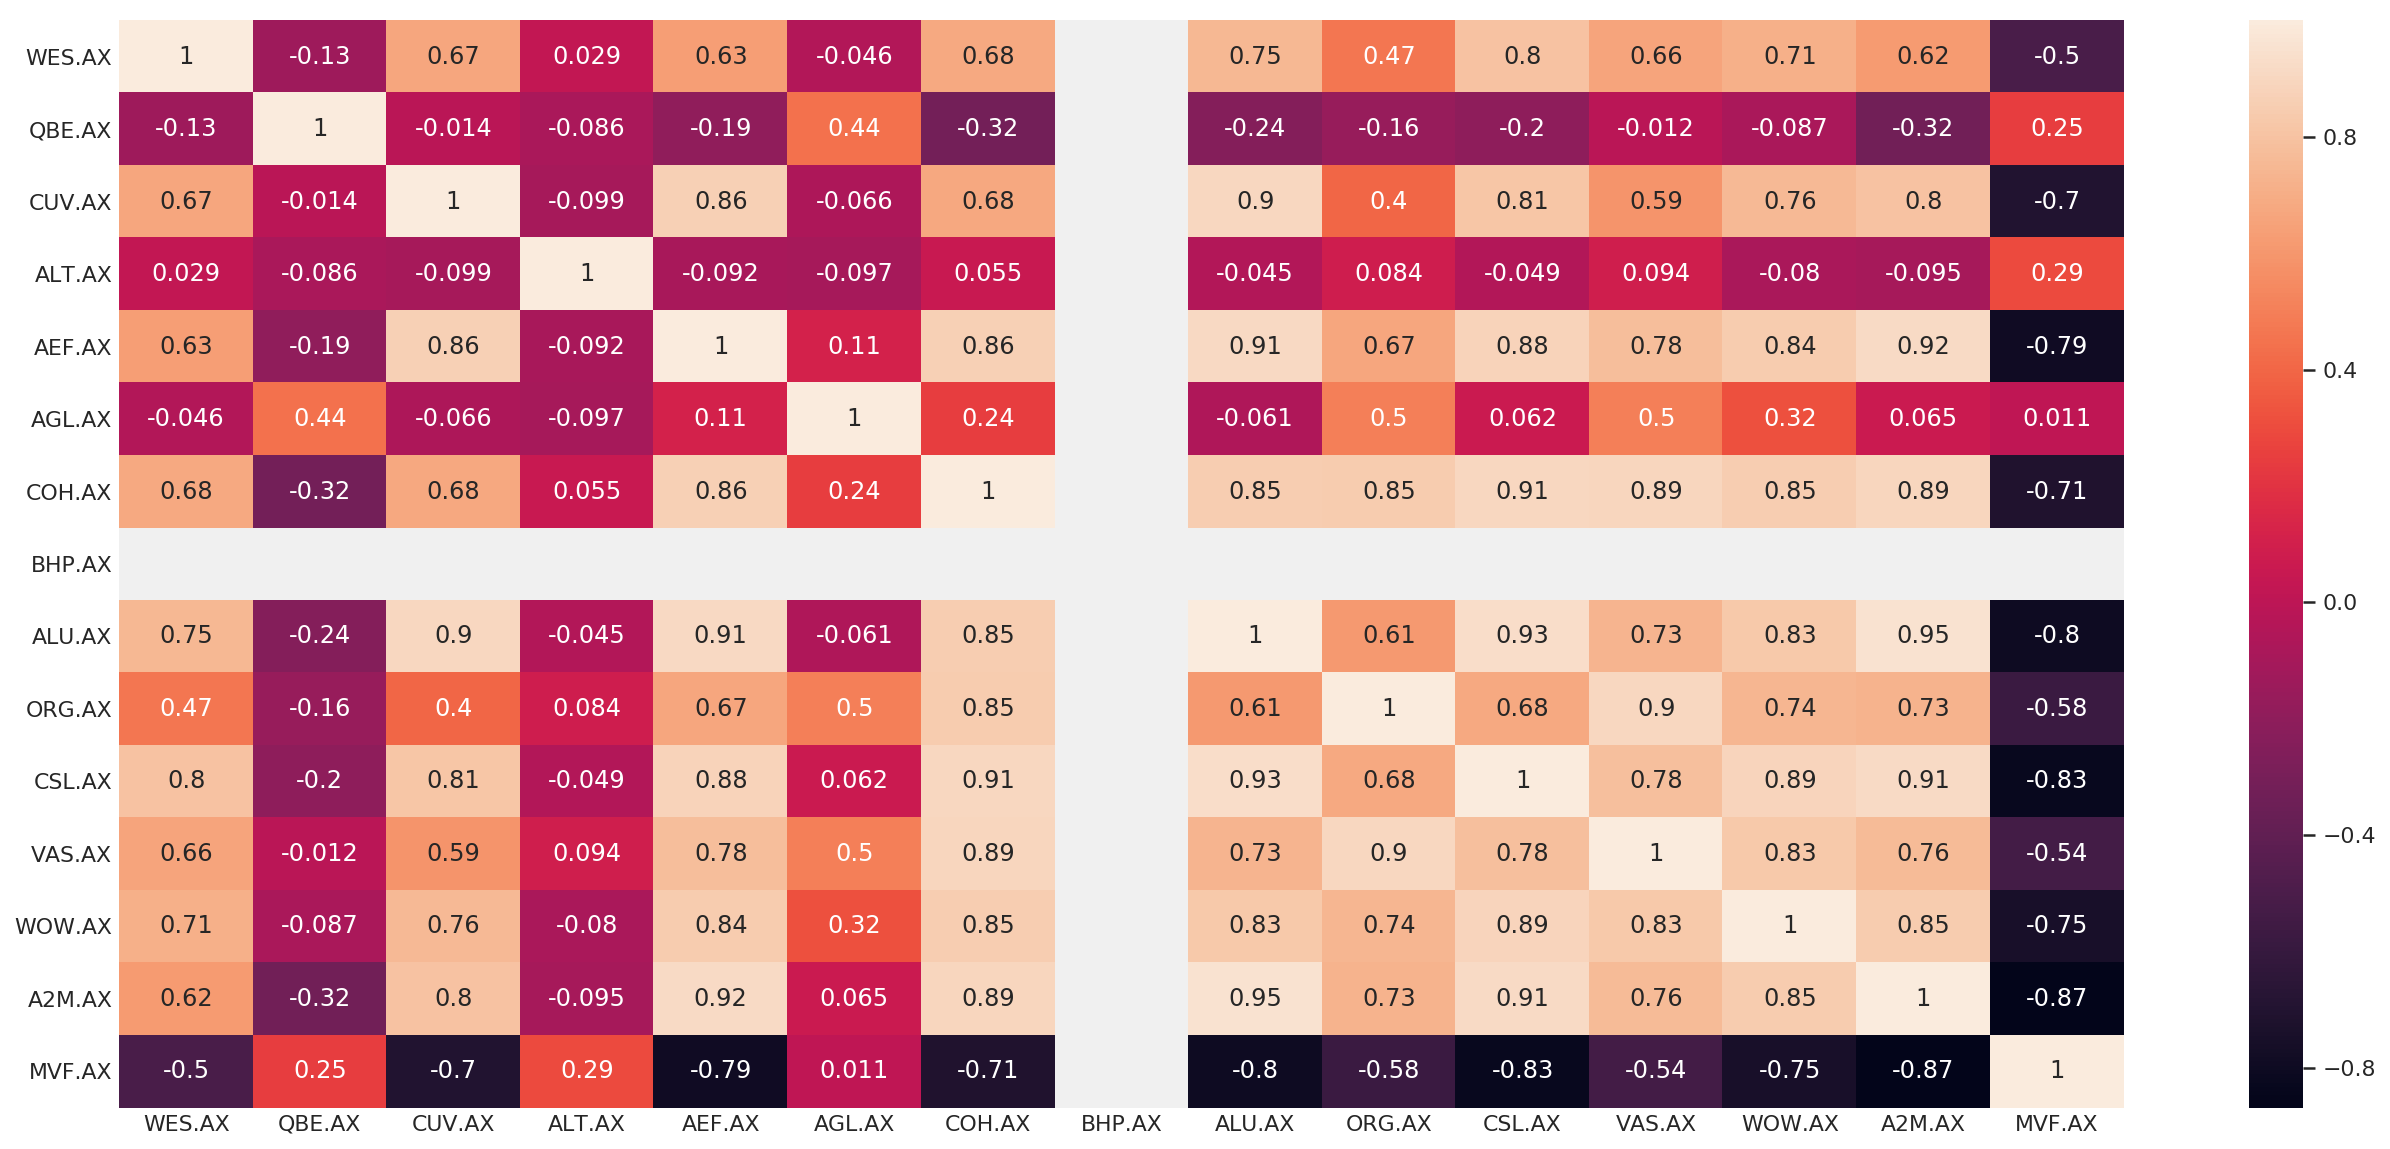

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1)

# corr_matrix = data[pd.MultiIndex.from_product([portfolio, ["Close"]])].corr()
corr_matrix = data.corr()

ax = sns.heatmap(corr_matrix, xticklabels=portfolio, yticklabels=portfolio, annot=True, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

# Custom Functions

In [48]:
def moving_average(array, window):
    
    weights = np.repeat(1.0, window)/window
    moving_average = np.convolve(array, weights, 'valid')
    
    return moving_average

In [49]:
def get_trade_points(prices, mean_prices):
    """

    :param prices: 1-dimensional np.array
    :param mean_price: 1-dimensional np.array
    return np.array
    """
    difference = prices - mean_prices

    zero_indices = np.argwhere(np.nan_to_num(np.diff(np.sign(difference)))).flatten()

    buy_indices = np.intersect1d(zero_indices, np.where(difference < 0)[0])

    sell_indices = np.intersect1d(zero_indices, np.where(difference > 0)[0])

    return buy_indices, sell_indices

In [50]:
def simulate(trade_array):
    
    pass

# Plots

In [60]:
from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook

linewidth = 3

source = ColumnDataSource(data=data.reset_index())

x = data.index
y = x

hover = HoverTool(
    tooltips=[("Date", "@x{%F}"),
              ("Price", "@y")],
    formatters={"x":"datetime"},
    mode = 'mouse')

# datetime.datetime

p = figure(plot_width = 900, plot_height = 600, title = 'Close Price', 
           x_axis_label = 'Date [Days]', x_axis_type='datetime', y_axis_label = 'Price',
           tools=[hover, 'box_select', 'box_zoom', 'pan', 'reset', 'save'])

sim = figure(plot_width = 900, plot_height = 600, title = 'Simulation', 
           x_axis_label = 'Date [Days]', x_axis_type='datetime', y_axis_label = 'Profit')

# To show in notebook
output_notebook()

sim.outline_line_color = None

sim.xgrid.visible = False
sim.ygrid.visible = False

sim.xgrid.visible = False
sim.ygrid.visible = False

sim.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
sim.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

sim.xaxis.axis_line_width = 0
sim.xaxis.axis_line_color = None

sim.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
sim.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

sim.yaxis.axis_line_width = 0
sim.yaxis.axis_line_color = None

p.outline_line_color = None

p.xgrid.visible = False
p.ygrid.visible = False

p.xgrid.visible = False
p.ygrid.visible = False

p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

p.xaxis.axis_line_width = 0
p.xaxis.axis_line_color = None

p.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
p.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

p.yaxis.axis_line_width = 0
p.yaxis.axis_line_color = None

price_plot = p.line(x, y, line_width=linewidth, color="blue", legend="Price", 
                    alpha=0.5, line_dash="solid", muted_alpha=0)
mean_plot = p.line(x, y, line_width=linewidth, color="red", legend="Rolling mean 15", alpha=0.5, muted_alpha=0)
buy_plot = p.circle(x, y, size=8, color="blue", alpha=1, fill_color="white", legend="Buy", muted_alpha=0)    
sell_plot = p.circle(x, y, size=8, color="red", alpha=1, fill_color="white", legend="Sell", muted_alpha=0)    

gain_plot = sim.line(x, y, line_width=linewidth, color="green", legend="Gain", alpha=0.5, line_dash="solid", muted_alpha=0)
zero_gain_plot = sim.line(x, 0, line_width=linewidth, color="black", legend="0", alpha=0.5, line_dash="dashed", muted_alpha=0)

def update(feature):
    
    prices = data.loc[:, feature].values
    mean = data.loc[:, feature].ewm(span=15, adjust=False).mean()
    
    assert len(prices) == mean.shape[0]
    
    price_plot.data_source.data['y'] = prices
    mean_plot.data_source.data['y'] = mean
    
    buy_indices, sell_indices = get_trade_points(prices, mean)
    
    mask_buy = data[feature].index[buy_indices]
    buy_plot.data_source.data['x'] = data.loc[mask_buy, feature].index
    buy_plot.data_source.data['y'] = data.loc[mask_buy, feature].values
    
    assert len(data.loc[mask_buy, feature].index) == len(data.loc[mask_buy, feature].values)
    
    mask_sell = data[feature].index[sell_indices]
    
    sell_plot.data_source.data['x'] = data.loc[mask_sell, feature].index
    sell_plot.data_source.data['y'] = data.loc[mask_sell, feature].values
    
    assert len(data.loc[mask_sell, feature].index) == len(data.loc[mask_sell, feature].values)
    
    gain = pd.concat([-data.loc[mask_buy, feature], data.loc[mask_sell, feature]])
    gain.sort_index(inplace=True)
    
    mask = gain.index
    gain_plot.data_source.data['x'] = data.loc[mask, feature].index
    gain_plot.data_source.data['y'] = gain.cumsum().values

    push_notebook()

p.legend.location = "top_left"
sim.legend.location = "top_left"

# Click in the legend to remove the corresponding line
p.legend.click_policy="mute"
sim.legend.click_policy="mute"

show(column(p, sim), notebook_handle=True)

interact(update, feature=portfolio)

Loading BokehJS ...

interactive(children=(Dropdown(description='feature', options=('WES.AX', 'QBE.AX', 'CUV.AX', 'ALT.AX', 'AEF.AX…

<function __main__.update(feature)>

# References

* 1. How to Apply a Basic Market Filter to the S&P/ASX 200 to Reduce Portfolio Risk and Limit Losses. src:  https://www.marketindex.com.au/asx-filter
*2 . Python for Finance, Part 3: Average Trading Strategy https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/


# Useless code

In [52]:
linewidth = 3
metric = "Cum Sum Pct Change"
# create a color iterator
colors = itertools.cycle(palette) 
rolling_columns = [days for days in data[share].columns.values.squeeze() if re.search("Rolling mean \d+", days)]
rolling_columns = ['Rolling mean 15', 'Rolling mean 90']

for share in portfolio:
    p = figure(plot_width = 900, plot_height = 600, title = '{}'.format(share), 
               x_axis_label = 'Date [Days]', x_axis_type='datetime', y_axis_label = 'Values')

    p.outline_line_color = None

    p.xgrid.visible = False
    p.ygrid.visible = False

    p.xgrid.visible = False
    p.ygrid.visible = False

    p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
    p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

    p.xaxis.axis_line_width = 0
    p.xaxis.axis_line_color = None

    p.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
    p.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

    p.yaxis.axis_line_width = 0
    p.yaxis.axis_line_color = None
    
    # muted_alpha controls the opacity of the line, when muted. muted_color controls the color

    p.line(data.loc[:, (share, metric)].index, data.loc[:, (share, metric)].values, line_width=linewidth, color="blue", legend="Cum Sum Pct Change", alpha=0.25, line_dash="solid")
    for color, rol_col in zip(colors, rolling_columns):
        p.line(data.loc[:, (share, metric)].index, data.loc[:, (share, rol_col)].values, line_width=linewidth, color=color, legend=rol_col, alpha=0.75, muted_alpha=0)
    
    mask_buy = data.loc[:, (share, "Trade")] == "Buy"
    p.circle(data[mask_buy].index, data.loc[mask_buy, (share, metric)].values, size=8, color="blue", alpha=1, fill_color="white", legend="Buy", muted_alpha=0)    
    
    mask_sell = data.loc[:, (share, "Trade")] == "Sell"
    p.circle(data[mask_sell].index, data.loc[mask_sell, (share, metric)].values, size=8, color="red", alpha=1, fill_color="white", legend="Sell", muted_alpha=0)    
    
    p.legend.location = "top_left"
    
    # Click in the legend to remove the corresponding line
    p.legend.click_policy="mute"
    # To show in notebook
    output_notebook()

    # Show the plot
    show(p)

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

x = np.linspace(0, 2*np.pi, 2000)
y = np.sin(x)

p = figure(title="simple line example", plot_height=300, plot_width=600, y_range=(-5,5),
           background_fill_color='#efefef')
r = p.line(x, y, color="#8888cc", line_width=1.5, alpha=0.8)

def update(f, w=1, A=1, phi=0):
    if   f == "sin": func = np.sin
    elif f == "cos": func = np.cos
    r.data_source.data['y'] = A * func(w * x + phi)
    push_notebook()

show(p, notebook_handle=True)

interact(update, f=["sin", "cos"], w=(0,50), A=(1,10), phi=(0, 20, 0.1))